<a href="https://colab.research.google.com/github/FGalvao77/Redes-Adversariais-Generativas-GANs---MNIST-dataset/blob/main/Redes_Adversariais_Generativas_(GANs)_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Redes Adversariais Generativas (GANs) - MNIST dataset**

---



<font size=4>Para essa atividade, usaremos o famoso conjunto de dados MNIST, que representa dígitos de 0 à 9 escritos a mão.</font>

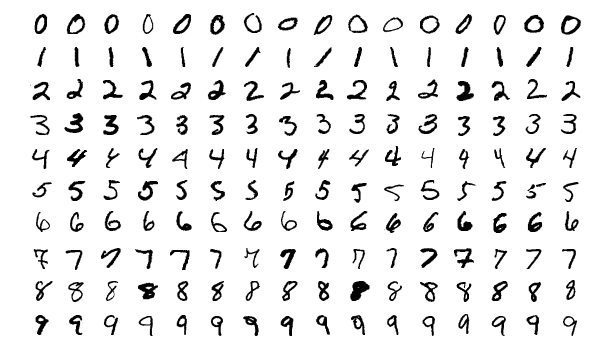

<font size=4>O primeiro passo é importar as bibliotecas, módulos/funções necessárias.</font>

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import keras

In [14]:
from tqdm import tqdm

from keras import initializers
from keras.datasets import mnist
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
# from keras.optimizers import Adan
from tensorflow import keras

<font size=4>Agora iremos definir algumas variáveis importantes.</font>

In [4]:
# instanciando o Keras para saber que estamos usando o tensorflow como nosso mecanismo de back-end
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [5]:
# instanciando a semente para podemos reproduzir o experimento e obter os mesmos resultados
np.random.seed(42)

In [6]:
# dimensão do nosso vetor de ruído aleatório
random_dim = 100

<font size=4>Criando outras funções necessárias.</font>

In [7]:
def load_dataset():
    # carregando o conjunto de dados
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    # normaliznada as nossas entradas para estarem no intervalo [-1, 1]
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    # convertendo o X_train com uma forma de (60000, 28, 28) para (60000, 784) então temos, 784 colunas por linha
    X_train = X_train.reshape(60_000, 784)
    return (X_train, y_train, X_test, y_test)

In [8]:
# função para utilizar o otimizador Adam
def get_optimizer():
    # return Adam(lr=0.0002, beta_1=0.5)
    optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)    # 2e-4 == 0.0002
    return optimizer

In [9]:
# função do gerador
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)

    return generator

In [10]:
# função do discriminador
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [11]:
# função da rede GAN
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # inicialmente definimos treinável como False, pois queremos treinar apenas o gerador ou o discriminador de cada vez
    discriminator.trainable = False
    # entrada da gan (ruído) serão vetores de 100 dimensões
    gan_input = Input(shape=(random_dim,))
    # a saída do gerador (uma imagem)
    X = generator(gan_input)
    # obter a saída do discriminador (probabilidade se a imagem é real ou não)
    gan_output = discriminator(X)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [12]:
# função que salvará as imagens geradas a cada 20 épocas
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)

    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

<font size=4>Treinando a rede GAN.</font>

100%|██████████| 468/468 [01:22<00:00,  5.66it/s]


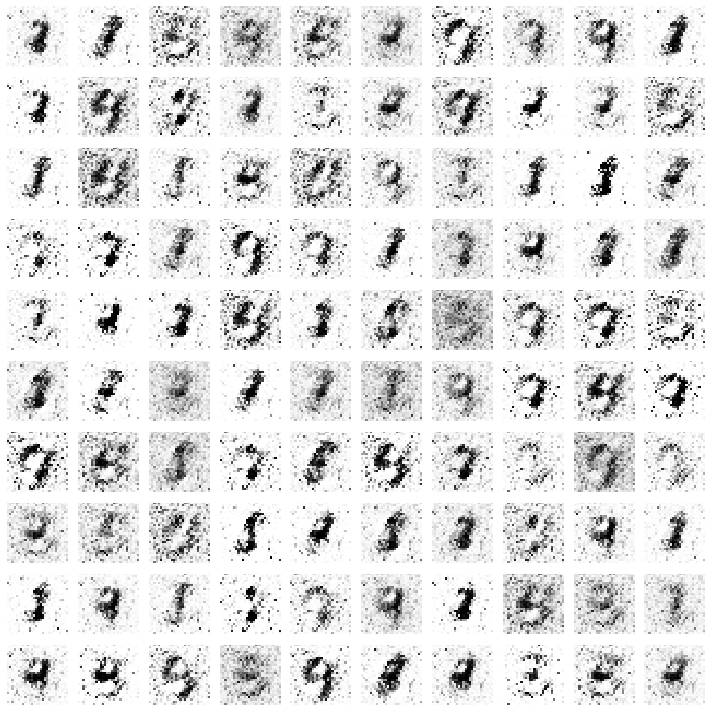

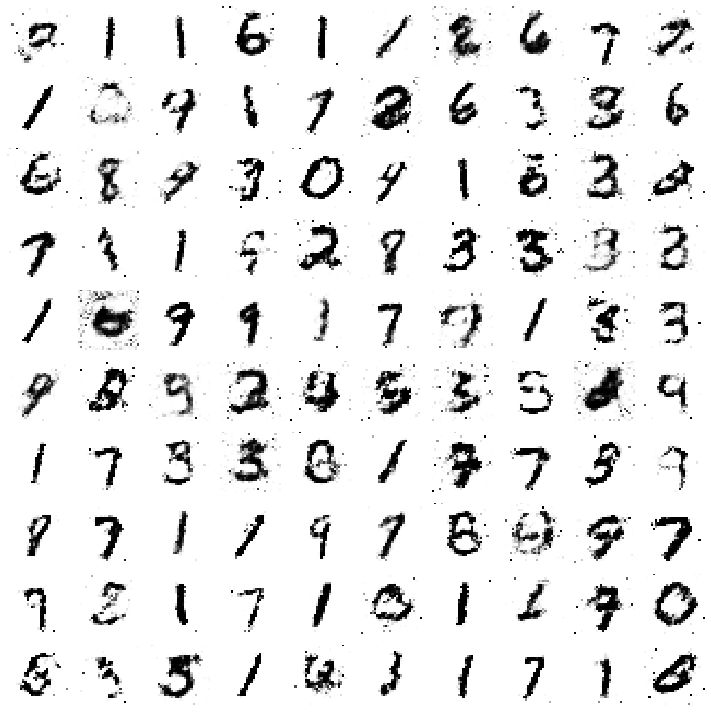

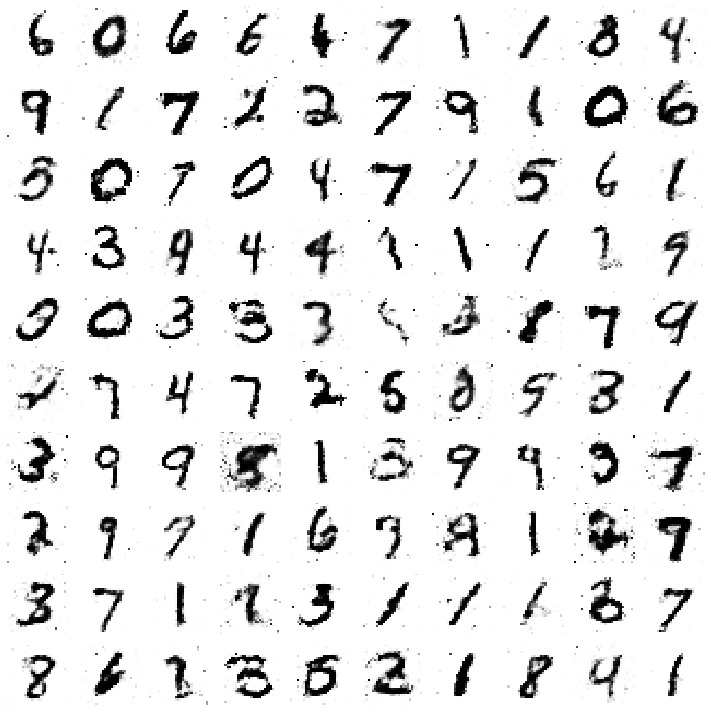

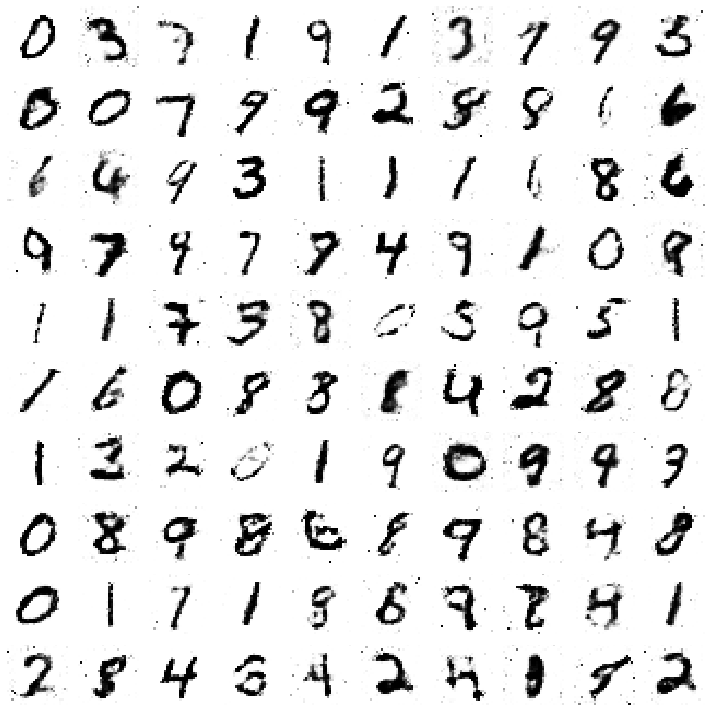

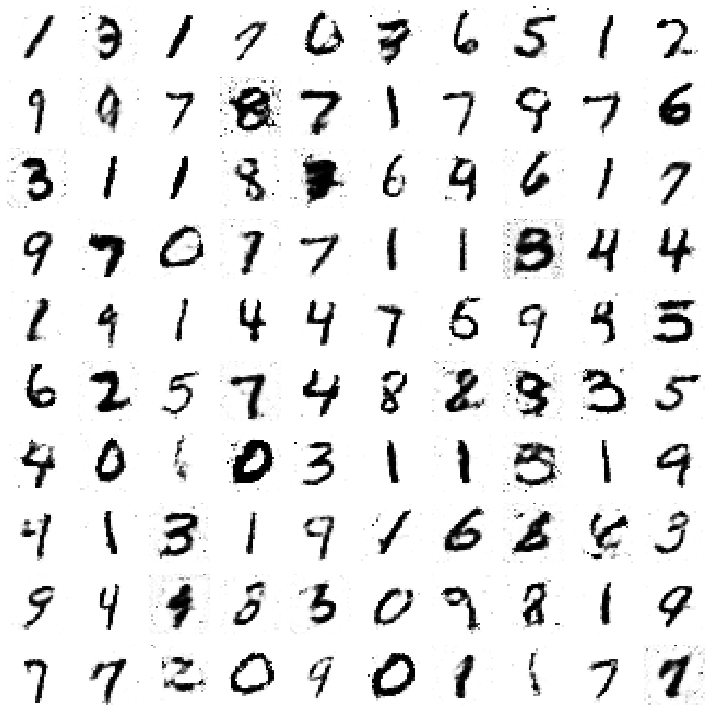

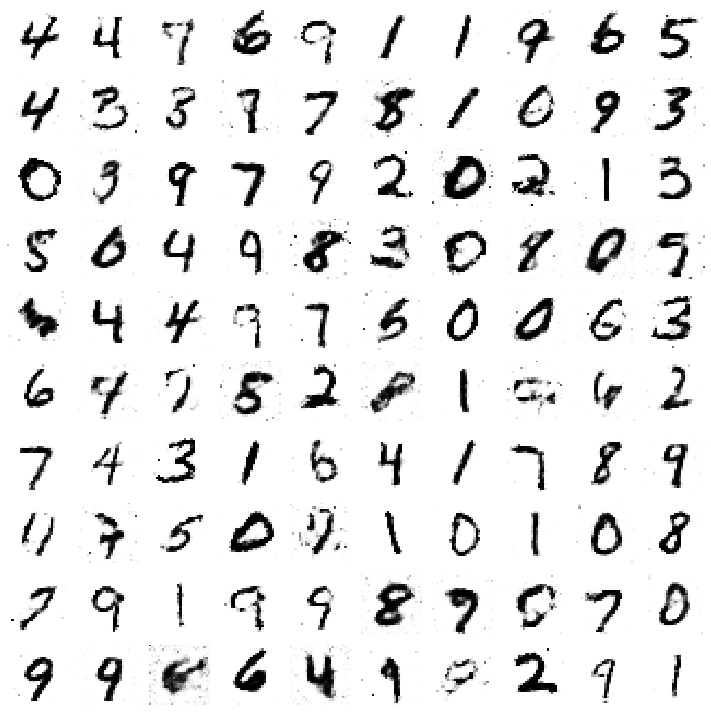

In [15]:
# função para treinar a rede
def train(epochs=1, batch_size=128):
    # obtendo os dados de treinamento e teste
    X_train, y_train, X_test, y_test = load_dataset()
    # dividindo os dados de treinamento em lotes de tamanho 128
    batch_count = int(X_train.shape[0] / batch_size)

    # construindo a rede GAN
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for i in range(1, epochs + 1):
        f'-'*15, 'Epoch %d' % i, '-'*15
        for _ in tqdm(range(batch_count)):
            # obtendo um conjunto aleatório de ruído de entrada e imagens
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

            # gerando imagens MNIST falsas
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # rótulos para dados gerados e reais
            y_dis = np.zeros(2 * batch_size)
            # suavização de etiqueta unilateral
            y_dis[:batch_size] = 0.9

            # treinando o discriminador
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # treinando o gerador
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if i == 1 or i % 20 == 0:
            plot_generated_images(i, generator)

if __name__ == '__main__':
    train(100, 128)